<a href="https://colab.research.google.com/github/JA4S/JANC/blob/main/JANC_RDC_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Environment

In [ ]:
!pip install cantera
from nondim import x0, P0, T0, t0
import janc.thermo as thermo
import janc.boundary as boundary
import janc.aux_func as aux_func
import janc.solver as solver
import cantera as ct
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm.auto import tqdm

# set JAX to use GPU
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')

# User-defined boundary conditions and source terms

In [ ]:
Lx = 0.20/x0
Ly = 0.08/x0

nx = 2000
ny = 800

##inlet boundary
#injection equivalence ratio
ratio = 1.0
yH2inj = (ratio/8*0.232)/(1 + ratio/8*0.232)
yO2inj = 0.232/(1 + ratio/8*0.232)

##outlet boundary
#back pressure
Pb = 101325/P0

Yinj = jnp.concatenate([jnp.array([yH2inj,yO2inj]),1e-20*jnp.ones((8-2))],axis=0)
Yinj_cor = jnp.expand_dims(Yinj,(1,2))
Yinj_cor = jnp.tile(Yinj_cor,(1,nx+2*3,1))
na = 8

In [ ]:
def inj_model(p):
    A1 = 1
    A3 = 5
    A2 = A3-A1
    R = thermo.get_R(Yinj_cor)
    gamma = 1.29
    C0 = jnp.sqrt(gamma*R*1.0)

    M = jnp.zeros_like(p)
    P1 = 1.0*(1+(gamma-1)/2*M**2)**(-gamma/(gamma-1))
    V1 = M*(1+(gamma-1)/2*M**2)**(-0.5)*C0
    MFC = A1*1.0/jnp.sqrt(1.0)*jnp.sqrt(gamma/R)*M*(1+(gamma-1)/2*M**2)**(-(gamma+1)/2/(gamma-1))
    A = 0.5
    P3 = p
    B = gamma/(gamma-1)*P3*A3/MFC
    C = -gamma/(gamma-1)*R*1.0
    V3 = (-B+jnp.sqrt(B**2-4*A*C))/(2*A)
    P2 = (MFC*(V3-V1)-P1*A1+P3*A3)/A2

    M1 = jnp.zeros_like(p)
    M2 = jnp.ones_like(p)
    p_cor = p

    for i in range(20):
        M = 0.5*(M1+M2)
        P1 = 1.0*(1+(gamma-1)/2*M**2)**(-gamma/(gamma-1))
        V1 = M*(1+(gamma-1)/2*M**2)**(-0.5)*C0
        MFC = A1*1.0/jnp.sqrt(1.0)*jnp.sqrt(gamma/R)*M*(1+(gamma-1)/2*M**2)**(-(gamma+1)/2/(gamma-1))
        A = 0.5
        B = gamma/(gamma-1)*P3*A3/MFC
        C = -gamma/(gamma-1)*R*1.0
        V3 = (-B+jnp.sqrt(B**2-4*A*C))/(2*A)
        P2 = (MFC*(V3-V1)-P1*A1+P3*A3)/A2

        M2 = jax.lax.select(P2>=P1,M,M2)
        M1 = jax.lax.select(P2<P1,M,M1)

    rho_cor = MFC/V3/A3
    v_cor = V3
    T_cor = p_cor/(R*rho_cor)
    _, gamma, h_cor, _, _ = thermo.get_thermo(T_cor,Yinj_cor)
    return v_cor, T_cor, h_cor, gamma

def boundary_conditions(U,aux):
    na = Yinj_cor.shape[0]

    U_periodic = jnp.concatenate([U[:,-4:-3,:],U[:,-3:-2,:],U[:,-2:-1,:],U,U[:,1:2,:],U[:,2:3,:],U[:,3:4,:]],axis=1)
    aux_periodic = jnp.concatenate([aux[:,-4:-3,:],aux[:,-3:-2,:],aux[:,-2:-1,:],aux,aux[:,1:2,:],aux[:,2:3,:],aux[:,3:4,:]],axis=1)
    state_periodic = U_periodic
    gamma_periodic = aux_periodic[0:1,:,:]
    T_periodic = aux_periodic[1:2,:,:]

    state_out = state_periodic[:,:,-1:]
    gamma_out = gamma_periodic[:,:,-1:]
    T_out = T_periodic[:,:,-1:]
    rho_out = state_out[0:1,:,:]
    u_out = state_out[1:2,:,:]/rho_out
    v_out = state_out[2:3,:,:]/rho_out
    Y_out = state_out[4:,:,:]/rho_out
    R_out = thermo.get_R(Y_out)
    p_out = rho_out*(R_out*T_out)
    a_out = jnp.sqrt(gamma_out*p_out/rho_out)
    mask = (v_out/a_out < 1.0)
    rho_cor_out = jax.lax.select(mask, Pb / (p_out / rho_out),rho_out)
    p_cor_out = jax.lax.select(mask, Pb*jnp.ones_like(p_out),p_out)
    T_cor_out = jax.lax.select(mask, p_cor_out/(rho_cor_out*R_out),T_out)
    _, gamma_out, h_out, _,_ = thermo.get_thermo(T_cor_out,Y_out)
    upper_bound_state = jnp.concatenate([rho_cor_out, rho_cor_out * u_out, rho_cor_out * v_out,
                      rho_cor_out*h_out - p_cor_out + 0.5 * rho_cor_out * (u_out ** 2 + v_out ** 2),
                      rho_cor_out * Y_out], axis=0)
    aux_up = jnp.concatenate([gamma_out,T_cor_out],axis=0)

    state_in = state_periodic[:,:,0:1]
    gamma_in = gamma_periodic[:,:,0:1]##
    T_in = T_periodic[:,:,0:1]
    rho_in = state_in[0:1,:,:]
    u_in = state_in[1:2,:,:]/rho_in
    v_in = state_in[2:3,:,:]/rho_in
    Y_in = state_in[4:,:,:]/rho_in
    _, _, h_in, R_in,_ = thermo.get_thermo(T_in,Y_in)
    p_in = rho_in*R_in*T_in

    u_temp = jnp.zeros_like(u_in)
    Y_temp = Yinj_cor
    v_temp, T_temp, h_temp, gamma_temp = inj_model(p_in)
    R_temp = thermo.get_R(Y_temp)
    rho_temp = p_in/(R_temp*T_temp)

    mask_in = (p_in >= 1.0)
    rho_cor_in = jax.lax.select(mask_in,rho_in,rho_temp)
    u_cor_in = jax.lax.select(mask_in,u_in,u_temp)
    v_cor_in = jax.lax.select(mask_in,-v_in,v_temp)
    T_cor_in = jax.lax.select(mask_in,T_in,T_temp)
    p_cor_in = p_in
    h_cor_in = jax.lax.select(mask_in,h_in,h_temp)
    Y_cor_in = jax.lax.select(jnp.tile(mask_in,(na,1,1)),Y_in,Y_temp)
    gamma_cor_in = jax.lax.select(mask_in,gamma_in,gamma_temp)

    lower_bound_state = jnp.concatenate([rho_cor_in, rho_cor_in * u_cor_in, rho_cor_in * v_cor_in,
                      rho_cor_in*h_cor_in - p_cor_in + 0.5 * rho_cor_in * (u_cor_in ** 2 + v_cor_in ** 2),
                      rho_cor_in * Y_cor_in], axis=0)
    aux_low = jnp.concatenate([gamma_cor_in,T_cor_in],axis=0)


    U_with_ghost_cell = jnp.concatenate([lower_bound_state,lower_bound_state,lower_bound_state,U_periodic,
                        upper_bound_state,upper_bound_state,upper_bound_state],axis=2)

    aux_with_ghost_cell = jnp.concatenate([aux_low,aux_low,aux_low,aux_periodic,
                        aux_up,aux_up,aux_up],axis=2)
    return U_with_ghost_cell.astype(jnp.float32),aux_with_ghost_cell.astype(jnp.float32)
    #return U_with_ghost_cell,aux_with_ghost_cell

# Calculations

In [ ]:

grid_set = {'Lx':Lx,'Ly':Ly,'nx':nx,'ny':ny}

thermo_set = {'is_detailed_chemistry':True,
          'chemistry_mechanism_diretory':'chem.txt',
          'thermo_model':'nasa7',
          'nasa7_mech':'gri30.yaml'}

boundary_set = {'boundary_conditions':boundary_conditions}
source_set = {'self_defined_source_terms':None}

In [ ]:
simulator = solver.set_solver(thermo_set,boundary_set,source_set,'implicit',grid_set)

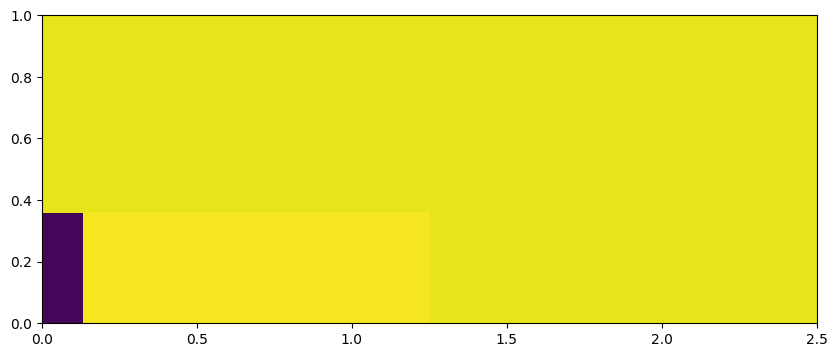

In [ ]:
def initial_conditions(ignition_width,ignition_height):
    Penv = 1*101325/P0; Tenv = 300/T0; yH2env = 0; yO2env = 0.232;
    Pignition = 20*101325/P0; Tignition = 1500/T0; Tfill = T0/T0;
    Yenv = np.concatenate([np.array([yH2env,yO2env]),1e-20*np.ones(8-2)])
    Yfill = np.concatenate([np.array([yH2inj,yO2inj]),1e-20*np.ones(8-2)])
    _,gamma_env,h_env,Renv,_ = thermo.get_thermo(np.array([[[Tenv]]]),jnp.expand_dims(Yenv,(1,2)))
    _,gamma_ignition,h_ignition,_,_ = thermo.get_thermo(np.array([[[Tignition]]]),jnp.expand_dims(Yfill,(1,2)))
    _,gamma_fill,h_fill,Rfill,_ = thermo.get_thermo(np.array([[[Tfill]]]),jnp.expand_dims(Yfill,(1,2)))

    gamma_env = gamma_env.squeeze()
    h_env = h_env.squeeze()
    Renv = Renv.squeeze()
    gamma_ignition = gamma_ignition.squeeze()
    h_ignition = h_ignition.squeeze()
    gamma_fill = gamma_fill.squeeze()
    h_fill = h_fill.squeeze()
    Rfill = Rfill.squeeze()

    rho_init = Penv/(Renv*Tenv)*np.ones((nx,ny))
    rhou_init = np.zeros((nx,ny))
    rhov_init = np.zeros((nx,ny))
    E_init = (Penv/(Renv*Tenv)*h_env - Penv)*np.ones((nx,ny))
    T_init = (Tenv)*np.ones((nx,ny))
    gamma_init = (gamma_env)*np.ones((nx,ny))
    rhoY_init = np.expand_dims(Penv/(Renv*Tenv)*Yenv,(1,2))*np.ones((8,nx,ny))


    div = 2
    rho_init = rho_init.at[0:ignition_width,0:ignition_height].set(Pignition/(Rfill*Tignition))
    E_init = E_init.at[0:ignition_width,0:ignition_height].set(Pignition/(Rfill*Tignition)*h_ignition - Pignition)
    T_init[0:ignition_width,0:ignition_height] = (Tignition)
    gamma_init = gamma_init.at[0:ignition_width,0:ignition_height].set(gamma_ignition)
    rhoY_init[:,0:ignition_width,0:ignition_height] = (np.expand_dims(rho_init[0:ignition_width,0:ignition_height],0)*np.tile(np.expand_dims(Yfill,(1,2)),(1,ignition_width,ignition_height)))


    rho_init = rho_init.at[ignition_width:round(nx/div),0:ignition_height].set(Penv/(Rfill*Tfill))
    E_init = E_init.at[ignition_width:round(nx/div),0:ignition_height].set(Penv/(Rfill*Tfill)*h_fill - Penv)
    T_init[ignition_width:round(nx/div),0:ignition_height] = (Tfill)
    gamma_init = gamma_init.at[ignition_width:round(nx/div),0:ignition_height].set(gamma_fill)
    rhoY_init[:,ignition_width:round(nx/div),0:ignition_height] = np.expand_dims(rho_init[ignition_width:round(nx/div),0:ignition_height],0)*np.tile(np.expand_dims(Yfill,(1,2)),(1,round(nx/div)-ignition_width,ignition_height))

    rho_init = jnp.expand_dims(rho_init,0)
    rhou_init = jnp.expand_dims(rhou_init,0)
    rhov_init = jnp.expand_dims(rhov_init,0)
    E_init = jnp.expand_dims(E_init,0)
    state_init = np.concatenate([rho_init,rhou_init,rhov_init,E_init,rhoY_init],axis=0)
    return jnp.array(state_init),jnp.concatenate([jnp.array([T_init]),jnp.array([gamma_init])],axis=0)


ignition_width = round(108);ignition_height = round(288)
#ignition_width = 14;ignition_height = 36
U,aux = initial_conditions(ignition_width,ignition_height)
plt.figure(figsize=(10, 4))
x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
X, Y = jnp.meshgrid(x, y, indexing='ij')
plt.contourf(X, Y, aux[-1], levels=50, cmap='viridis')

In [ ]:
T = simulator(U,aux,40000)

progress:   0%|          | 0/40000 [00:00<?, ?step/s]

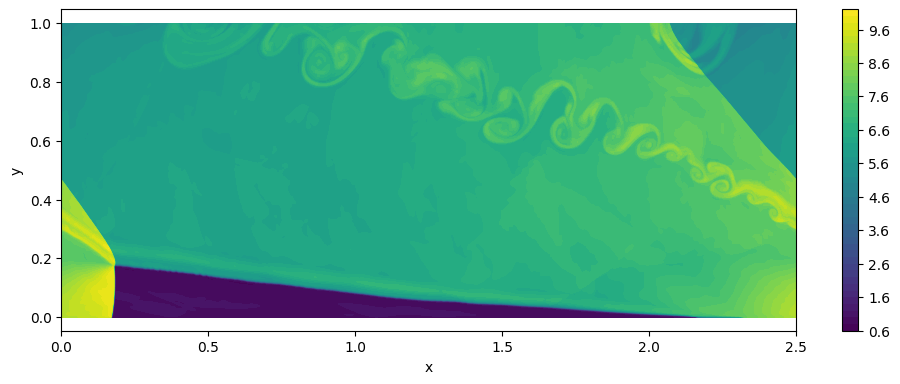

In [ ]:
plt.figure(figsize=(10, 4))
plt.contourf(X, Y, T[-1], levels=50, cmap='viridis')
#plt.clim(0, 4)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.tight_layout()
plt.axis('equal')
plt.show()

In [ ]:
T_np = np.array(T)

GIF保存完成！


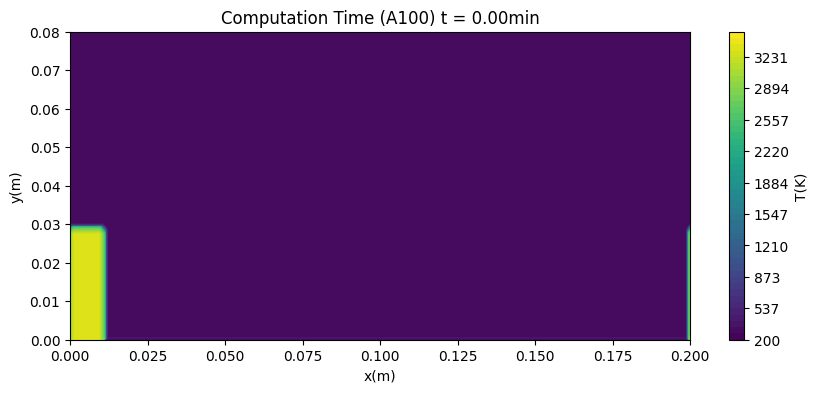

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


nt, nx, ny = 400, 2000, 800
data = 300*T_np



fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Frame 0")

levels = np.linspace(200.0, 3500.0, 50)

contour = ax.contourf(X*x0, Y*x0, data[0], levels=levels, cmap='viridis', vmin=200.0, vmax=3500.0)
cbar = fig.colorbar(contour)
cbar.set_label('T(K)')
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')

def update(frame):
    for coll in ax.collections:
        coll.remove()
    ax.contourf(X*x0, Y*x0, data[frame], levels=levels, cmap='viridis', vmin=200.0, vmax=3500.0)
    time = frame*100/13.24/60
    ax.set_title(f"Computation Time (A100) t = {time:.2f}min")
    return ax.collections

anim = FuncAnimation(fig, update, frames=nt, interval=100)


anim.save("/content/drive/MyDrive/animation3.gif", writer="pillow", fps=24, dpi=100)

print("GIF saved！")